# Import Data and Train Model


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler, AdamW
from datasets import load_metric
from torchsummary import summary
from sklearn import metrics
import seaborn as sns

import numpy as np
from skimage import io
from PIL import Image
import librosa

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd;
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from tqdm.auto import tqdm
import random

seed_number = 69
# torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Dataset


In [3]:
class Dataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [4]:
seizure_type = "absence"
main_folder_path = "melspectrograms/"
path = main_folder_path + seizure_type + "/"

train_x_absence = np.load(f"{path}/train_{seizure_type}_x.npy")

train_y_absence = np.load(f"{path}/train_{seizure_type}_y.npy")

validation_x_absence = np.load(f"{path}/validation_{seizure_type}_x.npy")

validation_y_absence = np.load(f"{path}/validation_{seizure_type}_y.npy")

test_x_absence = np.load(f"{path}/test_{seizure_type}_x.npy")

test_y_absence = np.load(f"{path}/test_{seizure_type}_y.npy")

In [5]:
seizure_type = "tonic-clonic"
main_folder_path = "melspectrograms/"
path = main_folder_path + seizure_type + "/"

train_x_tonic_clonic = np.load(f"{path}/train_{seizure_type}_x.npy")
train_y_tonic_clonic = np.load(f"{path}/train_{seizure_type}_y.npy")

validation_x_tonic_clonic = np.load(f"{path}/validation_{seizure_type}_x.npy")
validation_y_tonic_clonic = np.load(f"{path}/validation_{seizure_type}_y.npy")

test_x_tonic_clonic = np.load(f"{path}/test_{seizure_type}_x.npy")
test_y_tonic_clonic = np.load(f"{path}/test_{seizure_type}_y.npy")

In [6]:
seizure_type = "general"
main_folder_path = "melspectrograms/"
path = main_folder_path + seizure_type + "/"

train_x_general = np.load(f"{path}/train_{seizure_type}_x.npy")
train_y_general = np.load(f"{path}/train_{seizure_type}_y.npy")

validation_x_general = np.load(f"{path}/validation_{seizure_type}_x.npy")
validation_y_general = np.load(f"{path}/validation_{seizure_type}_y.npy")

test_x_general = np.load(f"{path}/test_{seizure_type}_x.npy")
test_y_general = np.load(f"{path}/test_{seizure_type}_y.npy")

In [7]:
for i, v in enumerate(train_y_tonic_clonic):
    if v == 1:
        train_y_tonic_clonic[i] = 2

for i, v in enumerate(validation_y_tonic_clonic):
    if v == 1:
        validation_y_tonic_clonic[i] = 2

for i, v in enumerate(test_y_tonic_clonic):
    if v == 1:
        test_y_tonic_clonic[i] = 2

for i, v in enumerate(train_y_general):
    if v == 1:
        train_y_general[i] = 3

for i, v in enumerate(validation_y_general):
    if v == 1:
        validation_y_general[i] = 3

for i, v in enumerate(test_y_general):
    if v == 1:
        test_y_general[i] = 3

In [8]:
train_x = np.concatenate(
    (train_x_absence, train_x_tonic_clonic, train_x_general), axis=0
)
train_y = np.concatenate(
    (train_y_absence, train_y_tonic_clonic, train_y_general), axis=0
)

validation_x = np.concatenate(
    (validation_x_absence, validation_x_tonic_clonic, validation_x_general), axis=0
)
validation_y = np.concatenate(
    (validation_y_absence, validation_y_tonic_clonic, validation_y_general), axis=0
)

test_x = np.concatenate((test_x_absence, test_x_tonic_clonic, test_x_general), axis=0)
test_y = np.concatenate((test_y_absence, test_y_tonic_clonic, test_y_general), axis=0)

In [9]:
# Add channel dimension to all sets
print(train_x.shape, validation_x.shape, test_x.shape)
train_x = np.expand_dims(train_x, axis=1)
validation_x = np.expand_dims(validation_x, axis=1)
test_x = np.expand_dims(test_x, axis=1)

print(train_x.shape, validation_x.shape, test_x.shape)

(18372, 40, 26) (3232, 40, 26) (1615, 40, 26)
(18372, 1, 40, 26) (3232, 1, 40, 26) (1615, 1, 40, 26)


In [10]:
train_dataset = Dataset(
    (train_x, train_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
validation_dataset = Dataset(
    (validation_x, validation_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
test_dataset = Dataset(
    (test_x, test_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

# Model


In [11]:
from torchvision.models import mobilenet_v3_small

model = mobilenet_v3_small()

In [12]:
from SZModel import SZModel

In [13]:
model_absence = SZModel()
model_absence.load_state_dict(torch.load("model/pytorch_models/absence_model.pt"))

model_absence = model_absence.to(device)
return_nodes = {
    "block2.4": "rr",
}
model_absence = create_feature_extractor(model_absence, return_nodes=return_nodes)


model_tonic_clonic = SZModel()
model_tonic_clonic.load_state_dict(
    torch.load("model/pytorch_models/tonic-clonic_model.pt")
)
model_tonic_clonic = model_tonic_clonic.to(device)
return_nodes = {
    "block2.4": "rr",
}
model_tonic_clonic = create_feature_extractor(
    model_tonic_clonic, return_nodes=return_nodes
)

model_general = SZModel()
model_general.load_state_dict(torch.load("model/pytorch_models/general_model.pt"))
model_general = model_general.to(device)
return_nodes = {
    "block2.4": "rr",
}
model_general = create_feature_extractor(model_general, return_nodes=return_nodes)

# summary(model_absence, (1, 40, 26), batch_size=1, device="cuda")
# summary(model_part_two, (3, 10, 10), batch_size=1, device="cuda")
# model_absence

In [14]:
class SZModel_Part_2(nn.Module):
    def __init__(self):
        super(SZModel_Part_2, self).__init__()
        self.model_absence = model_absence
        self.model_tonic_clonic = model_tonic_clonic
        self.model_general = model_general
        self.conv1 = nn.Conv2d(
            48, 16, (1, 1), stride=(1, 1), padding=(0, 0), bias=False
        )
        self.globalaveragepool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.classif_block = nn.Sequential(
            nn.Linear(16, 32),
            nn.Hardswish(),
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(32, 4),
        )

    def forward(self, x):
        a = self.model_absence(x)
        b = self.model_tonic_clonic(x)
        c = self.model_general(x)

        a, b, c = a["rr"], b["rr"], c["rr"]
        x = torch.cat((a, b, c), dim=1)
        x = F.relu(self.conv1(x))
        x = self.globalaveragepool(x)
        x = self.flatten(x)
        x = self.classif_block(x)
        return x

In [15]:
model_part_two = SZModel_Part_2()
model_part_two = model_part_two.to(device)

# Train


## Training Loop


In [16]:
batch_size = 1280
b_shuffle = True

train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=b_shuffle
)
validation_dataloader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=b_shuffle
)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=b_shuffle)

### Print Inputs


In [17]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Train // Background: {bk} // {seizure_type} Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(validation_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Validation // Background: {bk} // Seizure: {sz}")

Train // Background: 14621 // general Seizure: 3751
Validation // Background: 3178 // Seizure: 54


In [18]:
# # Example of sample

# for i, v in enumerate(train_dataloader):
#     print(v[0][0].shape, v[1].shape)
#     print(v[1][0])
#     plt.imshow(np.transpose(v[0][0], (1, 2, 0)))
#     break

### 70/20/10 Training


In [19]:
num_epochs = 500
learning_rate = 5e-5
optimizer = torch.optim.Adam(model_part_two.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [20]:
# # Example Input

# x = 28
# example_image = None
# for batch in train_dataloader:
#     example_image = batch[0][x]
#     print(batch[1][x])
#     break

# plt.imshow(example_image[0].cpu().numpy(), cmap="gray")

In [21]:
b_loss = True
print(f"Training {seizure_type} for {num_epochs} epochs")
print(" ")

loss_track = []
valid_loss_track = []
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1} / {num_epochs}")

    model_part_two.train()
    model_absence.eval()
    model_tonic_clonic.eval()
    model_general.eval()
    loss_batch = 0.0
    batch_counter = 0
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(torch.int64)

        optimizer.zero_grad()

        model_part_two.train()
        outputs_2 = model_part_two(inputs)

        loss = loss_fn(outputs_2, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        loss_batch += loss
        batch_counter += 1

    if b_loss:
        print(f"Train Loss: {(loss_batch / batch_counter)}")
    loss_track.append((loss_batch / batch_counter))

    model_part_two.eval()
    valid_loss_batch = 0.0
    eval_batch_counter = 0
    with torch.no_grad():
        for vbatch in validation_dataloader:
            vinputs, vlabels = vbatch
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            vlabels = vlabels.to(torch.int64)

            voutputs = model_part_two(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            valid_loss_batch += vloss
            eval_batch_counter += 1

    if b_loss:
        print(f"Validation Loss: {(valid_loss_batch / eval_batch_counter)}")
    valid_loss_track.append((valid_loss_batch / eval_batch_counter))
    torch.cuda.empty_cache()
    print("─" * 50)
print("Training Complete")

Training general for 500 epochs
 
Epoch: 1 / 500
Train Loss: 1.3723382949829102
Validation Loss: 1.372894525527954
──────────────────────────────────────────────────
Epoch: 2 / 500
Train Loss: 1.3607184886932373
Validation Loss: 1.359990119934082
──────────────────────────────────────────────────
Epoch: 3 / 500
Train Loss: 1.3519320487976074
Validation Loss: 1.3501638174057007
──────────────────────────────────────────────────
Epoch: 4 / 500
Train Loss: 1.3410849571228027
Validation Loss: 1.3373141288757324
──────────────────────────────────────────────────
Epoch: 5 / 500
Train Loss: 1.3324648141860962
Validation Loss: 1.3235336542129517
──────────────────────────────────────────────────
Epoch: 6 / 500
Train Loss: 1.3226696252822876
Validation Loss: 1.3127058744430542
──────────────────────────────────────────────────
Epoch: 7 / 500
Train Loss: 1.3127025365829468
Validation Loss: 1.2971057891845703
──────────────────────────────────────────────────
Epoch: 8 / 500
Train Loss: 1.30156528

tensor(0.3043)


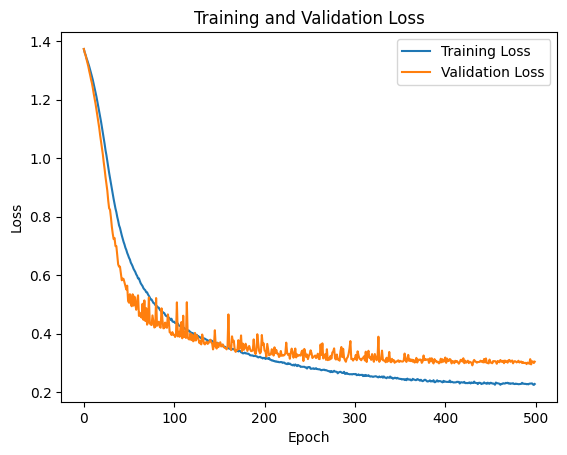

In [23]:
# Plot losses
a = []
for i in range(len(loss_track)):
    a.append(loss_track[i].to("cpu").detach())

b = []
for i in range(len(valid_loss_track)):
    b.append(valid_loss_track[i].to("cpu").detach())
print(b[-1])

plt.plot(range(len(a)), a, label="Training Loss")
plt.plot(range(len(b)), b, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"results/pytorch_inference/default/combined/combined_loss.png")
plt.show()

Test Loop


In [25]:
a, b, c, d = 0, 0, 0, 0
for i in test_dataloader:
    inputs, labels = i
    for j in labels:
        if j == torch.tensor([0.0]):
            a += 1
        elif j == torch.tensor([1.0]):
            b += 1
        elif j == torch.tensor([2.0]):
            c += 1
        else:
            d += 1

print(f"Test // Background: {a} // Absence: {b} // Tonic-Clonic: {c} // General: {d}")
print(f"Total: {a+b+c+d}")

Test // Background: 1300 // Absence: 20 // Tonic-Clonic: 159 // General: 136
Total: 1615


In [26]:
actual_test = []
predicted_test = []

for batch in test_dataloader:

    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    labels = labels.to(torch.int64)
    model_part_two.eval()

    with torch.no_grad():
        output = model_part_two(inputs)

    output = nn.functional.softmax(output, dim=1)

    for i in labels:
        actual_test.append(i)

    for i in output:
        predicted_test.append(i)

In [40]:
print(actual_test[0].cpu().numpy().item())
print(predicted_test[0].cpu().numpy())

0
[0.948673   0.00676958 0.03573704 0.00882026]


In [54]:
y_true = []
y_pred = []
y_score = []

print(len(actual_test), len(predicted_test))

for i in range(len(actual_test)):
    y_true.append(actual_test[i].cpu().numpy())
    y_pred.append(predicted_test[i].cpu().numpy())
    y_score.append(predicted_test[i].cpu().numpy())

for i, v in enumerate(y_true):
    if v == 0:
        y_true[i] = 0
    elif v == 1:
        y_true[i] = 1
    elif v == 2:
        y_true[i] = 2
    else:
        y_true[i] = 3

for i, v in enumerate(y_pred):
    a = max(v)
    for m, j in enumerate(v):
        if j == a:
            y_pred[i] = m

y_true = np.array(y_true)

1615 1615


In [104]:
print(y_score[0])

[0.948673   0.00676958 0.03573704 0.00882026]


In [44]:
labels = ["Background", "Absence", "Tonic-Clonic", "General"]
cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
cm_norm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true")

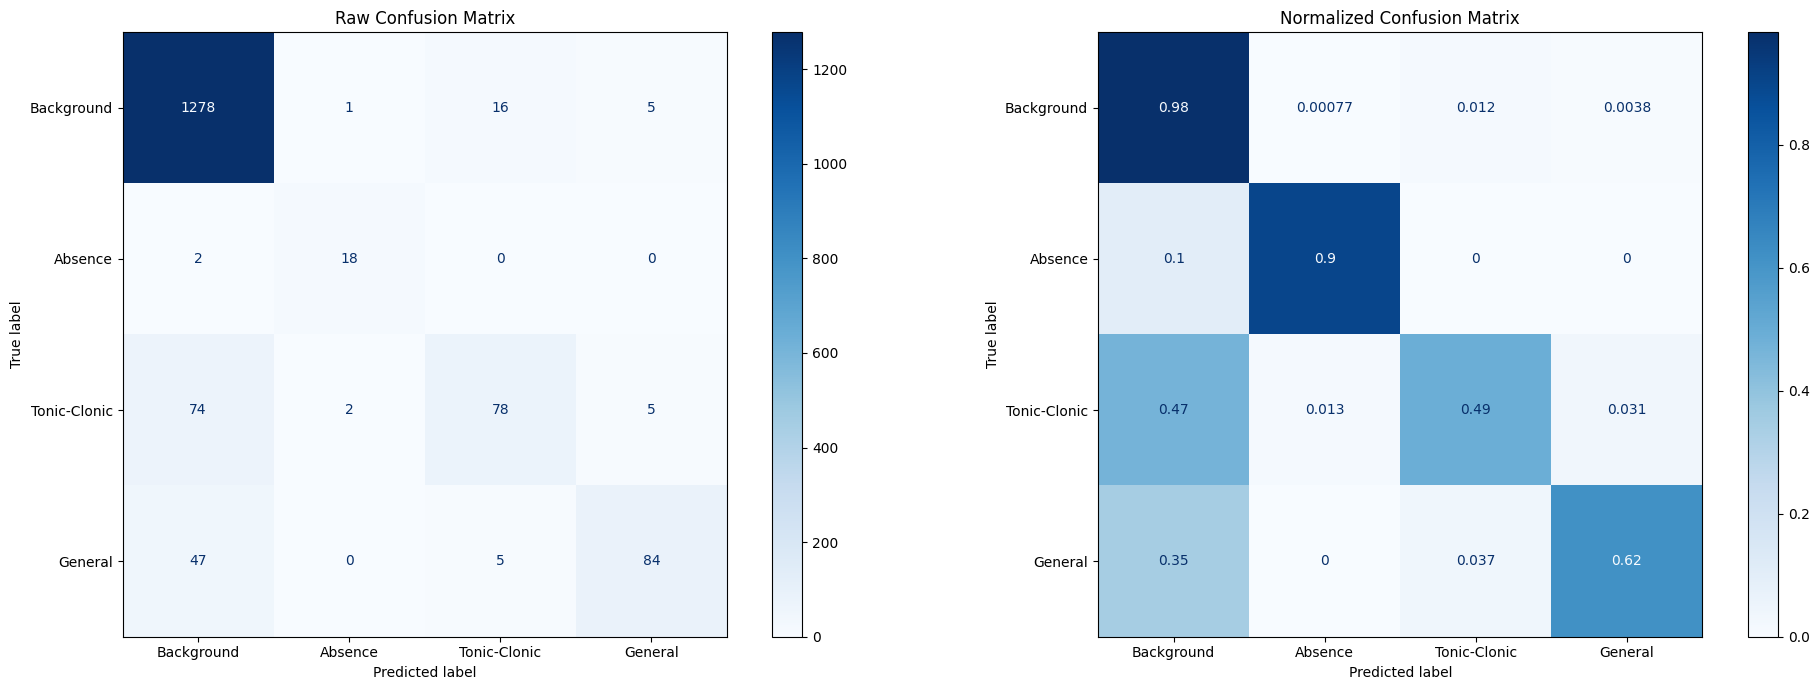

In [100]:
plt.figure(figsize=(20, 7))

a = metrics.ConfusionMatrixDisplay(cm, display_labels=labels)
b = metrics.ConfusionMatrixDisplay(cm_norm, display_labels=labels)

plt.subplot(1, 2, 1)


a.plot(ax=plt.gca(), cmap="Blues", xticks_rotation="horizontal")
plt.title("Raw Confusion Matrix")

plt.subplot(1, 2, 2)
b.plot(ax=plt.gca(), cmap="Blues", xticks_rotation="horizontal")
plt.title("Normalized Confusion Matrix")

plt.savefig(f"results/pytorch_inference/default/combined/combined_confusion_matrix.png")

plt.tight_layout()
plt.show()

In [91]:
auc_score = (
    metrics.roc_auc_score(
        y_true=y_true, y_score=y_score, average="macro", multi_class="ovo"
    )
) * 100
print(f"ROC AUC: {auc_score}")

ROC AUC: 92.1112876125293


In [96]:
TP = 18 + 78 + 84
FN = 2 + (74 + 2 + 5) + (47 + 5)

total_s = TP + FN
# print(total_s)

sensitivity = (TP / total_s) * 100
print(f"Sensitivity: {sensitivity} ({TP} / {total_s})")

TN = 1278
FP = 1 + 16 + 5
total_b = TN + FP
# print(total_b)

specificity = (TN / total_b) * 100
print(f"Specificity: {specificity} ({TN} / {total_b})")

GMEAN = (math.sqrt(sensitivity / 100 * specificity / 100)) * 100
print(f"G-Mean: {GMEAN}")

accuracy = ((TP + TN) / (total_s + total_b)) * 100
print(f"Accuracy: {accuracy}")

Sensitivity: 57.14285714285714 (180 / 315)
Specificity: 98.3076923076923 (1278 / 1300)
G-Mean: 74.95053313741282
Accuracy: 90.27863777089783


In [98]:
df = pd.DataFrame(
    {
        "Model": ["Combined"],
        "Accuracy": [accuracy],
        "Sensitivity": [sensitivity],
        "Specificity": [specificity],
        "ROC AUC": [auc_score],
        "G-Mean": [GMEAN],
    }
)

df.to_csv(f"results/pytorch_inference/default/combined/combined_results.csv")
df

,Model,Accuracy,Sensitivity,Specificity,ROC AUC,G-Mean
0,Combined,90.278638,57.142857,98.307692,92.111288,74.950533


In [105]:
torch.save(model_part_two.state_dict(), f"model/pytorch_models/combined_2_model.pt")